In [ ]:
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

In [2]:
import torch
print(torch.cuda.is_available())

True


In [4]:
import torch 
from torch import nn, optim 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt

In [6]:
# data transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]) 
])

In [8]:
# Load Dataset 

train_dataset = datasets.MNIST(root='./data',train=True, download=True,transform = transform) 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 


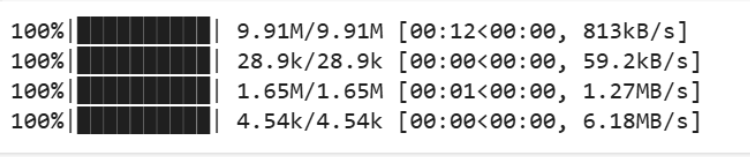

In [15]:
# Generator  

class Generator(nn.Module): 
    def __init__(self, z_dim):
        
        super(Generator, self).__init__() 
        # Neural Network Layers  
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 256), 
            nn.ReLU(True), 
            nn.Linear(256, 512), 
            nn.ReLU(True), 
            nn.Linear(512,1024),
            nn.ReLU(True), 
            nn.Linear(1024,28*28), 
            nn.Tanh() 
        )
    def forward(self, z): 
        return self.fc(z).view(-1, 1, 28, 28)


In [19]:
# Discriminator 
class Discriminator(nn.Module):
    def __init__(self): 
        super(Discriminator, self).__init__() 
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024), 
            nn.LeakyReLU(0.2), 
            nn.Linear(1024, 512), 
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256), 
            nn.LeakyReLU(0.2), 
            nn.Linear(256, 1), 
            nn.Sigmoid()            
        )
    def forward(self, x): 
        return self.fc(x)
    

In [21]:
criterion = nn.BCELoss()

z_dim = 100  # Latent vector size
lr = 0.0002  # Learning rate 

G = Generator(z_dim).cuda()
D = Discriminator().cuda()

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999)) 

In [23]:
num_epochs = 5 

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.cuda()
        real_labels = torch.full((real_images.size(0),), 1.0, device='cuda', dtype=torch.float)
        fake_labels = torch.full((real_images.size(0),), 0.0, device='cuda', dtype=torch.float) 
        optimizer_D.zero_grad() 

        output_real = D(real_images)
        d_loss_real = criterion(output_real.view(-1), real_labels)
        d_loss_real.backward() 
        z = torch.randn(real_images.size(0), z_dim).cuda()
        fake_images = G(z)
        output_fake = D(fake_images.detach())  # Detach fake images to avoid updating generator
        d_loss_fake = criterion(output_fake.view(-1), fake_labels)
        d_loss_fake.backward()   

        d_loss = d_loss_real + d_loss_fake
        optimizer_D.step() 
        optimizer_G.zero_grad() 

        output_fake = D(fake_images)
        g_loss = criterion(output_fake.view(-1), real_labels)  # Fake images as real
        g_loss.backward() 

        optimizer_G.step()
        if i % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')
       


Epoch [0/5], Step [0/938], D Loss: 1.3507, G Loss: 0.7024
Epoch [0/5], Step [100/938], D Loss: 1.2363, G Loss: 1.0518
Epoch [0/5], Step [200/938], D Loss: 0.2959, G Loss: 1.8980
Epoch [0/5], Step [300/938], D Loss: 0.7925, G Loss: 1.6101
Epoch [0/5], Step [400/938], D Loss: 0.4949, G Loss: 2.1198
Epoch [0/5], Step [500/938], D Loss: 0.6281, G Loss: 4.4133
Epoch [0/5], Step [600/938], D Loss: 1.0556, G Loss: 3.9537
Epoch [0/5], Step [700/938], D Loss: 0.3323, G Loss: 3.1455
Epoch [0/5], Step [800/938], D Loss: 1.0047, G Loss: 2.5770
Epoch [0/5], Step [900/938], D Loss: 0.2349, G Loss: 2.2600
Epoch [1/5], Step [0/938], D Loss: 0.2111, G Loss: 3.1216
Epoch [1/5], Step [100/938], D Loss: 0.6502, G Loss: 4.1246
Epoch [1/5], Step [200/938], D Loss: 0.0696, G Loss: 6.0388
Epoch [1/5], Step [300/938], D Loss: 0.1526, G Loss: 7.6353
Epoch [1/5], Step [400/938], D Loss: 0.8468, G Loss: 7.5370
Epoch [1/5], Step [500/938], D Loss: 0.6689, G Loss: 5.8498
Epoch [1/5], Step [600/938], D Loss: 0.1530,

In [ ]:
# Generate a batch of fake images 

z = torch.randn(16, z_dim).cuda() 
fake_images = G(z) 

fake_images = fake_images * 0.5 + 0.5 

fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(fake_images[i*4 + j].cpu().detach().numpy().squeeze(), cmap='gray')
        ax[i, j].axis('off')
plt.show()

